In [ ]:
import torch
import torchvision.transforms as transforms
import numpy as np
import os
from torchvision.models import inception_v3
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from collections import defaultdict
from sklearn.manifold import TSNE
import seaborn as sns
from scipy.stats import entropy
import lpips
import time
from tqdm import tqdm

### Split the combined dataset to train_augmented and train_original

In [ ]:
base_dir = "../data/combined_dataset_split/train"
augmented_dir = "../data/combined_dataset_split/train_augmented"
original_dir = "../data/combined_dataset_split/train_original"

print(f"Current working directory: {os.getcwd()}")

base_dir = os.path.abspath(base_dir)
augmented_dir = os.path.abspath(augmented_dir)
original_dir = os.path.abspath(original_dir)

print(f"Source directory: {base_dir}")
print(f"Original destination directory: {original_dir}")
print(f"Augmented destination directory: {augmented_dir}")

os.makedirs(augmented_dir, exist_ok=True)
os.makedirs(original_dir, exist_ok=True)

target_size = (224, 224)

categories = ["cardboard", "metal", "paper", "plastic", "glass", "trash"]

for category in categories:
    category_path = os.path.join(base_dir, category)
    aug_category_path = os.path.join(augmented_dir, category)
    orig_category_path = os.path.join(original_dir, category)
    
    os.makedirs(aug_category_path, exist_ok=True)
    os.makedirs(orig_category_path, exist_ok=True)

    if not os.path.exists(category_path):
        print(f"Skipping category {category}: source directory not found at {category_path}")
        continue

    files = os.listdir(category_path)
    if not files:
        print(f"No files found in category {category} at {category_path}")
        continue

    print(f"Processing {len(files)} files in category {category}...")

    for filename in files:
        src_path = os.path.join(category_path, filename)

        if not os.path.isfile(src_path):
            print(f"Skipping {src_path}: not a file")
            continue

        if "_aug" in filename:
            dest_path = os.path.join(aug_category_path, filename)
            dest_type = "augmented"
        else:
            dest_path = os.path.join(orig_category_path, filename)
            dest_type = "original"

        print(f"Processing {filename} as {dest_type}...")

        try:
            img = cv2.imread(src_path)
            if img is None:
                print(f"Warning: Could not load image {src_path}, skipping")
                continue

            img_resized = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA)

            cv2.imwrite(dest_path, img_resized)
            print(f"Saved resized image to {dest_path}")

            os.remove(src_path)
            print(f"Removed original file from {src_path}")

        except Exception as e:
            print(f"Error processing {src_path}: {e}")
            continue

print("Dataset successfully separated into original and augmented folders with resized images!")

for category in categories:
    orig_category_path = os.path.join(original_dir, category)
    aug_category_path = os.path.join(augmented_dir, category)
    
    orig_files = os.listdir(orig_category_path) if os.path.exists(orig_category_path) else []
    aug_files = os.listdir(aug_category_path) if os.path.exists(aug_category_path) else []
    
    print(f"Category {category}:")
    print(f"  Original images: {len(orig_files)} files")
    print(f"  Augmented images: {len(aug_files)} files")

Current working directory: c:\Users\vidia\OneDrive\Documents\Courses_Semester02\Machine_Learning_Practical\mlp_assignment\mlp_assignment\src
Source directory: c:\Users\vidia\OneDrive\Documents\Courses_Semester02\Machine_Learning_Practical\mlp_assignment\mlp_assignment\data\combined_dataset_split\train
Original destination directory: c:\Users\vidia\OneDrive\Documents\Courses_Semester02\Machine_Learning_Practical\mlp_assignment\mlp_assignment\data\combined_dataset_split\train_original
Augmented destination directory: c:\Users\vidia\OneDrive\Documents\Courses_Semester02\Machine_Learning_Practical\mlp_assignment\mlp_assignment\data\combined_dataset_split\train_augmented
Processing 1472 files in category cardboard...
Processing cardboard_aug_diffusion_1001.png as augmented...
Saved resized image to c:\Users\vidia\OneDrive\Documents\Courses_Semester02\Machine_Learning_Practical\mlp_assignment\mlp_assignment\data\combined_dataset_split\train_augmented\cardboard\cardboard_aug_diffusion_1001.pn

### Mapping original to augumented images

In [ ]:
original_dir = "../data/combined_dataset_split/train_original"
augmented_dir = "../data/combined_dataset_split/train_augmented"

categories = ["cardboard", "metal", "paper", "trash", "plastic", "glass"]

image_pairs = {}

for category in categories:
    orig_category_path = os.path.join(original_dir, category)
    aug_category_path = os.path.join(augmented_dir, category)

    original_images = {os.path.splitext(img)[0]: img for img in os.listdir(orig_category_path) if img.endswith(('.jpg', '.png'))}

    grouped_images = defaultdict(list)

    for aug_img in os.listdir(aug_category_path):
        if not aug_img.endswith(('.jpg', '.png')):
            continue

        aug_base = aug_img.split("_aug_")[0]

        if aug_base in original_images:
            grouped_images[original_images[aug_base]].append(aug_img)
        else:
            print(f"Warning: No matching original image found for augmented image {aug_img} in category {category}")

    image_pairs[category] = grouped_images

for key, value in list(image_pairs["cardboard"].items())[:100]:  
    print(f"Original: {key}, Augmented: {value}")

# T-SNE

/opt/miniconda3/envs/mlp/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/miniconda3/envs/mlp/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


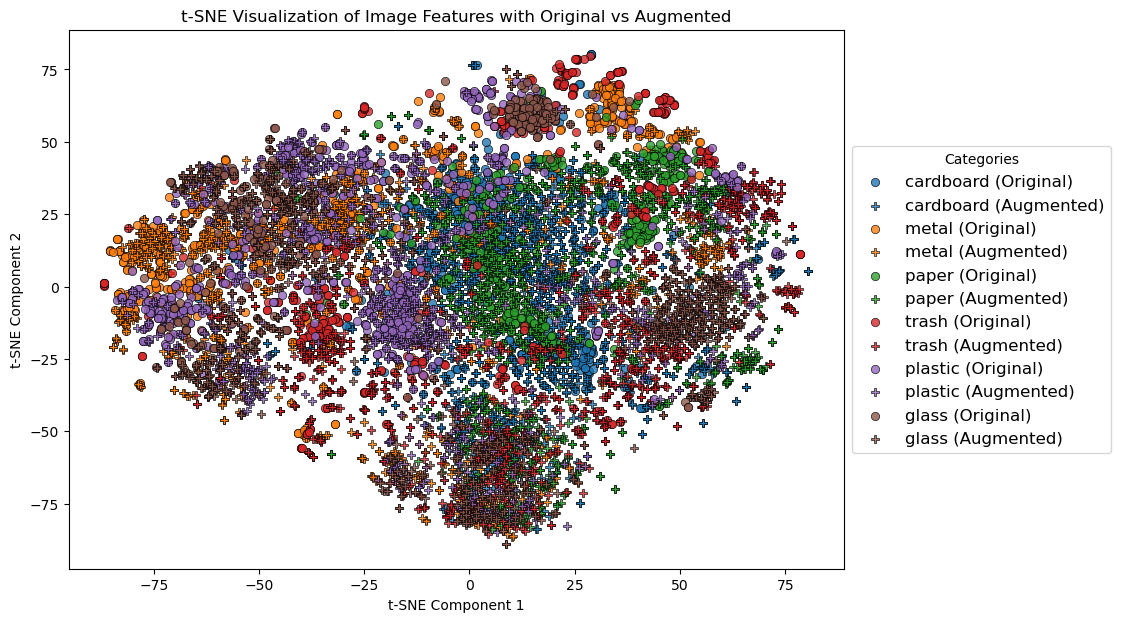

In [ ]:
original_dir = "../data/dataset_balanced/train"

categories = ["cardboard", "metal", "paper", "trash", "plastic", "glass"]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
inception_model = inception_v3(pretrained=True, transform_input=True).to(device)
inception_model.fc = torch.nn.Identity()
inception_model.eval()

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def get_features(image_paths):
    features = []
    labels = []
    is_augmented = []
    for img_path, label, is_aug in image_paths:
        image = cv2.imread(img_path)
        if image is None:
            continue
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = transform(image).unsqueeze(0).to(device)
        with torch.no_grad():
            feature = inception_model(image)
        features.append(feature.cpu().numpy().squeeze())
        labels.append(label)
        is_augmented.append(is_aug)
    return np.array(features), np.array(labels), np.array(is_augmented)

image_paths = []
for category in categories:
    category_path = os.path.join(original_dir, category)
    for img_name in os.listdir(category_path):
        img_path = os.path.join(category_path, img_name)
        is_aug = "_aug" in img_name 
        image_paths.append((img_path, category, is_aug))

features, labels, is_augmented = get_features(image_paths)

n_samples = features.shape[0]
if n_samples < 2:
    raise ValueError("Not enough valid feature vectors for t-SNE!")
perplexity = min(30, n_samples - 1)
tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
tsne_results = tsne.fit_transform(features)

colors = sns.color_palette("tab10", n_colors=len(categories))
color_dict = {category: colors[idx] for idx, category in enumerate(categories)}
label_dict = {category: idx for idx, category in enumerate(categories)}

numeric_labels = np.array([label_dict[label] for label in labels])

marker_dict = {False: "o", True: "P"}

plt.figure(figsize=(10, 7))

for category, color in color_dict.items():
    for is_aug, marker in marker_dict.items():
        idx = (numeric_labels == label_dict[category]) & (is_augmented == is_aug)
        plt.scatter(tsne_results[idx, 0], tsne_results[idx, 1], 
                    color=color, label=f"{category} ({'Augmented' if is_aug else 'Original'})",
                    alpha=0.8, edgecolor='k', marker=marker, linewidth=0.55)

plt.legend(title="Categories", loc="best", fontsize="large", bbox_to_anchor=(1, 0.8))

plt.title("t-SNE Visualization of Image Features with Original vs Augmented")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")

plt.show()

## KL

In [ ]:
def compute_kl_divergence(original_features, augmented_features, num_bins=50):
    """
    Computes KL Divergence between original and augmented feature distributions.
    """
    hist_orig, bins = np.histogram(original_features, bins=num_bins, density=True)
    hist_aug, _ = np.histogram(augmented_features, bins=bins, density=True) 

    hist_orig += 1e-10
    hist_aug += 1e-10

    kl_div = entropy(hist_orig, hist_aug)
    return kl_div

kl_results = {}
category_sample_counts = {}
total_samples = 0
weighted_kl_sum = 0 

for category in categories:
    orig_features = features[(numeric_labels == label_dict[category]) & (is_augmented == False)]
    aug_features = features[(numeric_labels == label_dict[category]) & (is_augmented == True)]

    sample_count = len(aug_features)
    category_sample_counts[category] = sample_count
    total_samples += sample_count

    if len(orig_features) > 1 and len(aug_features) > 1:
        kl_div_score = compute_kl_divergence(orig_features.flatten(), aug_features.flatten())
        kl_results[category] = kl_div_score

        weighted_kl_sum += kl_div_score * sample_count
    else:
        kl_results[category] = None

weighted_kl_avg = weighted_kl_sum / total_samples if total_samples > 0 else None

print("**KL Divergence Scores (Original vs Augmented)**")
for category, kl_score in kl_results.items():
    if kl_score is not None:
        print(f"{category}: KL Divergence = {kl_score:.4f} (Samples: {category_sample_counts[category]})")
    else:
        print(f"{category}: Not enough data to compute KL Divergence.")

if weighted_kl_avg is not None:
    print(f"\n**Weighted Average KL Divergence: {weighted_kl_avg:.4f}**")
else:
    print("\nNot enough data to compute Weighted KL Average.")

**KL Divergence Scores (Original vs Augmented)**
cardboard: KL Divergence = 0.0002 (Samples: 1104)
metal: KL Divergence = 0.0018 (Samples: 840)
paper: KL Divergence = 0.0045 (Samples: 1072)
trash: KL Divergence = 0.0016 (Samples: 1076)
plastic: KL Divergence = 0.0015 (Samples: 736)
glass: KL Divergence = 0.0014 (Samples: 1136)

**Weighted Average KL Divergence: 0.0018**


# LPIPS

In [ ]:
original_dir = "../data/combined_dataset_split/train_original"
augmented_dir = "../data/combined_dataset_split/train_augmented"

categories = ["cardboard", "metal", "paper", "trash", "plastic", "glass"]

image_pairs = {}

for category in categories:
    orig_category_path = os.path.join(original_dir, category)
    aug_category_path = os.path.join(augmented_dir, category)

    original_images = {os.path.splitext(img)[0]: img for img in os.listdir(orig_category_path) if img.endswith(('.jpg', '.png'))}

    grouped_images = defaultdict(list)

    for aug_img in os.listdir(aug_category_path):
        if not aug_img.endswith(('.jpg', '.png')):
            continue

        aug_base = aug_img.split("_aug_")[0]

        if aug_base in original_images:
            grouped_images[original_images[aug_base]].append(aug_img)
        else:
            print(f"Warning: No matching original image found for augmented image {aug_img} in category {category}")

    image_pairs[category] = grouped_images

for key, value in list(image_pairs["cardboard"].items())[:100]:  
    print(f"Original: {key}, Augmented: {value}")

In [ ]:
def load_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (256, 256))
    image = torch.tensor(image).permute(2, 0, 1).float() / 255.0
    return image.unsqueeze(0)

In [ ]:
original_dir = "../data/dataset_erasing_augmented_split/train_original"
augmented_dir = "../data/dataset_erasing_augmented_split/train_augmented"

categories = ["cardboard", "metal", "paper", "trash", "plastic", "glass"]
lpips_scores_list = []

try:
    lpips_model = lpips.LPIPS(net='vgg')
except Exception as e:
    print(f"Error initializing LPIPS model: {e}")
    exit()

def load_image(img_path):
    try:
        img = cv2.imread(img_path)
        if img is None:
            raise ValueError("Image not loaded properly")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = torch.from_numpy(img).permute(2, 0, 1).float() / 255.0 * 2 - 1
        img = img.unsqueeze(0)
        return img
    except Exception as e:
        print(f"Error loading image {img_path}: {e}")
        return None

start_time = time.time()
print(f"Process started at: {time.ctime()}")

image_pairs = {}
for category in categories:
    orig_path = os.path.join(original_dir, category)
    aug_path = os.path.join(augmented_dir, category)
    
    orig_files = set(os.listdir(orig_path)) if os.path.exists(orig_path) else set()
    aug_files = set(os.listdir(aug_path)) if os.path.exists(aug_path) else set()
    
    image_pairs[category] = {}
    for orig in orig_files:
        matches = [aug for aug in aug_files if orig.split('.')[0] in aug]
        if matches:
            image_pairs[category][orig] = matches

total_pairs = sum(len(aug_images) for category in image_pairs.values() for aug_images in category.values())
print(f"Total image pairs to process: {total_pairs}")

with tqdm(total=total_pairs, desc="Processing images") as pbar:
    for category in categories:
        orig_category_path = os.path.join(original_dir, category)
        aug_category_path = os.path.join(augmented_dir, category)

        if not os.path.exists(orig_category_path) or not os.path.exists(aug_category_path):
            print(f"Skipping category {category}: directory not found")
            continue

        for original_img, aug_images in image_pairs[category].items():
            original_path = os.path.join(orig_category_path, original_img)

            if not os.path.exists(original_path) or not aug_images:
                pbar.update(len(aug_images))
                continue

            original = load_image(original_path)
            if original is None:
                pbar.update(len(aug_images))
                continue

            for aug_img in aug_images:
                aug_path = os.path.join(aug_category_path, aug_img)
                augmented = load_image(aug_path)

                if augmented is None:
                    pbar.update(1)
                    continue

                try:
                    lpips_score = lpips_model(original, augmented)
                    lpips_scores_list.append({
                        "Category": category,
                        "Original": original_img,
                        "Augmented": aug_img,
                        "LPIPS": lpips_score.item()
                    })
                except Exception as e:
                    print(f"Error computing LPIPS for {original_img} vs {aug_img}: {e}")
                
                pbar.update(1)

df_lpips = pd.DataFrame(lpips_scores_list)

end_time = time.time()
execution_time = end_time - start_time
print(f"Process completed at: {time.ctime()}")
print(f"Total execution time: {execution_time:.2f} seconds")
print(f"Processed {len(df_lpips)} image pairs successfully")

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


C:\Users\vidia\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\vidia\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\vidia\anaconda3\envs\mlp\Lib\site-packages\lpips\weights\v0.1\vgg.pth
Process started at: Fri Mar 21 21:00:08 2025
Total image pairs to process: 13920


Processing images: 100%|██████████| 13920/13920 [23:31<00:00,  9.86it/s]

Process completed at: Fri Mar 21 21:23:40 2025
Total execution time: 1411.67 seconds
Processed 13920 image pairs successfully


In [ ]:
mean_lpips_per_category = df_lpips.groupby('Category')['LPIPS'].mean().to_dict()

for category, mean_lpips in mean_lpips_per_category.items():
    print(f"Category: {category}, Mean LPIPS score: {mean_lpips:.4f}")